In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 13 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## 状態空間モデルを用いた制御系設計

<img src="ss_probpng.png" width="600px">

### 状態空間モデル

In [69]:
A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]
P = ss(A, B, C, D)
print(P)

A = [[ 0.  1.]
 [-4.  5.]]

B = [[0.]
 [1.]]

C = [[1. 0.]
 [0. 1.]]

D = [[0.]
 [0.]]



安定性のチェック

In [70]:
np.linalg.eigvals(P.A)

array([1., 4.])

可制御性のチェック

In [71]:
Vc = ctrb(P.A, P.B)
print('Vc=', Vc)

np.linalg.det(Vc)

Vc= [[0. 1.]
 [1. 5.]]


-1.0

### 極配置による設計    

In [77]:
Pole = [-5+3j, -5-3j]
K = -acker(P.A, P.B, Pole)
K

matrix([[-30., -15.]])

閉ループ系の極

In [78]:
Acl = P.A + P.B*K
np.linalg.eigvals(Acl)

array([-5.+3.j, -5.-3.j])

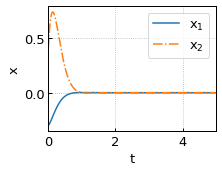

In [79]:
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 5, 0.01)
X0 = [-0.3, 0.4]
x, t = initial(Pfb, Td, X0) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.', label = '$x_2$')

plot_set(ax, 't', 'x', 'best')

### 最適レギュレータ

In [92]:
Q = [ [100, 0], [0, 1]]
R = 1

K, X, E = lqr(P.A, P.B, Q, R)
K = -K

print('--- フィードバックゲイン ---')
print(K)
print(-(1/R)*P.B.T*X)
print('--- 閉ループ極 ---')
print(E)
print(np.linalg.eigvals(P.A+P.B*K))

--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]
[[ -6.77032961 -11.28813639]]
--- 閉ループ極 ---
[-3.1440682+0.94083196j -3.1440682-0.94083196j]
[-3.14406819+0.94083198j -3.14406819-0.94083198j]


ハミルトン行列

In [82]:
H1 = np.c_[P.A, -P.B*(1/R)*P.B.T]
H2 = np.c_[ Q, P.A.T]
H = np.r_[H1, -H2]
eigH = np.linalg.eigvals(H)
print(eigH)

print('--- ハミルトン行列の安定固有値 ---')
eigH_stable = [ i for i in eigH if i < 0]
print(eigH_stable)

K = -acker(P.A, P.B, eigH_stable)
print('--- フィードバックゲイン ---')
print(K)

[-3.14406819+0.94083198j -3.14406819-0.94083198j  3.14406819+0.94083198j
  3.14406819-0.94083198j]
--- ハミルトン行列の安定固有値 ---
[(-3.144068193779283+0.9408319760374358j), (-3.144068193779283-0.9408319760374358j)]
--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]


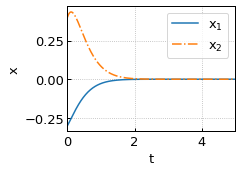

In [93]:
Acl = P.A + P.B*K
Pfb = ss(Acl, P.B, P.C, P.D)

tdata = np.arange(0, 5, 0.01)
xini, tini = initial(Pfb, tdata, [-0.3, 0.4]) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(tini, xini[:,0], label = '$x_1$')
ax.plot(tini, xini[:,1], ls = '-.', label = '$x_2$')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.grid(ls=':')
ax.legend()

円条件（最適レギュレータのロバスト性）

In [94]:
L = ss(P.A, P.B, -K, 0) # 開ループ系

In [95]:
margin(L)

(0.44294291177336015,
 60.491329194745106,
 2.645537660478436,
 10.521006470656348)

位相余裕が 60.49[deg] となっている

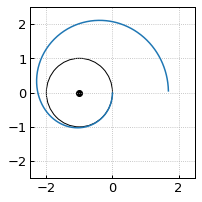

In [96]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(3, 3))
x, y, w = nyquist(L, logspace(-2,3,1000), Plot=False)
ax.plot(x, y)
# ax.plot(x, -y, ls='--')
ax.scatter(-1, 0, color='k')

ax.grid(ls=':')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

c = patches.Circle(xy=(-1, 0), radius=1, fill=False, ec='k')
ax.add_patch(c)

fig.tight_layout()

開ループ系のナイキスト軌跡が (-1, 0j) を中心とする単位円の中に入らない．

これにより，位相余裕が 60 [deg] 以上であることが保証される

## 積分型サーボ系

In [97]:
A = '0 1; -4 5'
B = '0; 1'
C = '1 0'
D = '0'
P = ss(A, B, C, D)
print(P)

A = [[ 0.  1.]
 [-4.  5.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]



In [98]:
Abar = np.r_[ np.c_[P.A, np.zeros((2,1))], -np.c_[ P.C, 0 ] ]
Bbar = np.c_[ P.B.T, 0 ].T
Cbar = np.c_[ P.C, 0 ]

In [99]:
Pole = [-1, -1, -5]
F = -acker(Abar, Bbar, Pole)
F

matrix([[ -7., -12.,   5.]])

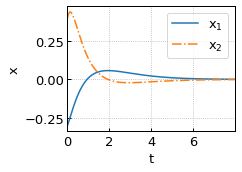

In [100]:
Acl = Abar + Bbar*F
Pfb = ss(Acl, Bbar, np.eye(3), np.zeros((3,1)))

Td = np.arange(0, 8, 0.01)
Ud = 0.2 * (Td>0)
x, t, _ = lsim(Pfb, Ud, Td, [-0.3, 0.4, 0])
 
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.',label = '$x_2$')
# ax.plot(t, Ud, c='k')
plot_set(ax, 't', 'x', 'best')